In [1]:
import torch
import matplotlib.pyplot as plt

from utils import utils
from models.dit import DiT
from rectified_flow.rectified_flow import RectifiedFlow

utils.set_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dit = DiT.from_pretrained("/root/autodl-tmp/dit_cifar/checkpoint-600000", "dit", True).to(device)

Model loaded from /root/autodl-tmp/dit_cifar/checkpoint-600000/dit_ema.pt


In [3]:
print(dit.final_conv.weight)

Parameter containing:
tensor([[[[-5.8471e-04, -6.5891e-03, -5.3173e-04],
          [-5.5544e-03, -2.4346e-01, -3.1502e-03],
          [-5.8792e-04, -4.2293e-03, -4.1066e-04]],

         [[-6.8771e-04, -5.6922e-03, -5.9984e-04],
          [-4.6635e-03,  4.9695e-02, -2.6813e-03],
          [-6.0179e-04, -4.1448e-03, -4.8297e-04]],

         [[ 3.2184e-04, -2.7262e-03,  2.1780e-04],
          [-2.8316e-03, -4.4741e-01, -1.8538e-03],
          [ 4.4840e-05, -1.1509e-03,  4.6150e-05]]],


        [[[-9.3938e-04, -6.6447e-03, -7.9876e-04],
          [-5.7606e-03,  1.0973e-01, -3.2159e-03],
          [-8.3564e-04, -4.6271e-03, -6.6006e-04]],

         [[-1.4384e-04, -6.2899e-03, -1.3751e-04],
          [-5.1362e-03, -5.5572e-01, -3.0055e-03],
          [-2.8355e-04, -3.6920e-03, -1.4294e-04]],

         [[-1.7233e-04, -1.5927e-03, -1.4989e-04],
          [-1.5228e-03,  1.6215e-02, -1.0417e-03],
          [-1.6384e-04, -1.3489e-03, -1.6093e-04]]],


        [[[-2.5769e-04, -6.4819e-03, -1.9726

In [3]:
rf_func = RectifiedFlow(
    data_shape=(3, 32, 32),
    model=dit,
    device=device,
)

In [4]:
from rectified_flow.samplers import EulerSampler

X_0 = torch.randn(130, 3, 32, 32, device=device)

euler_sampler = EulerSampler(
    rectified_flow=rf_func,
    num_steps=100,
    num_samples=130,
)

euler_sampler.sample_loop(X_0=X_0)

Number of function evaluations: 50


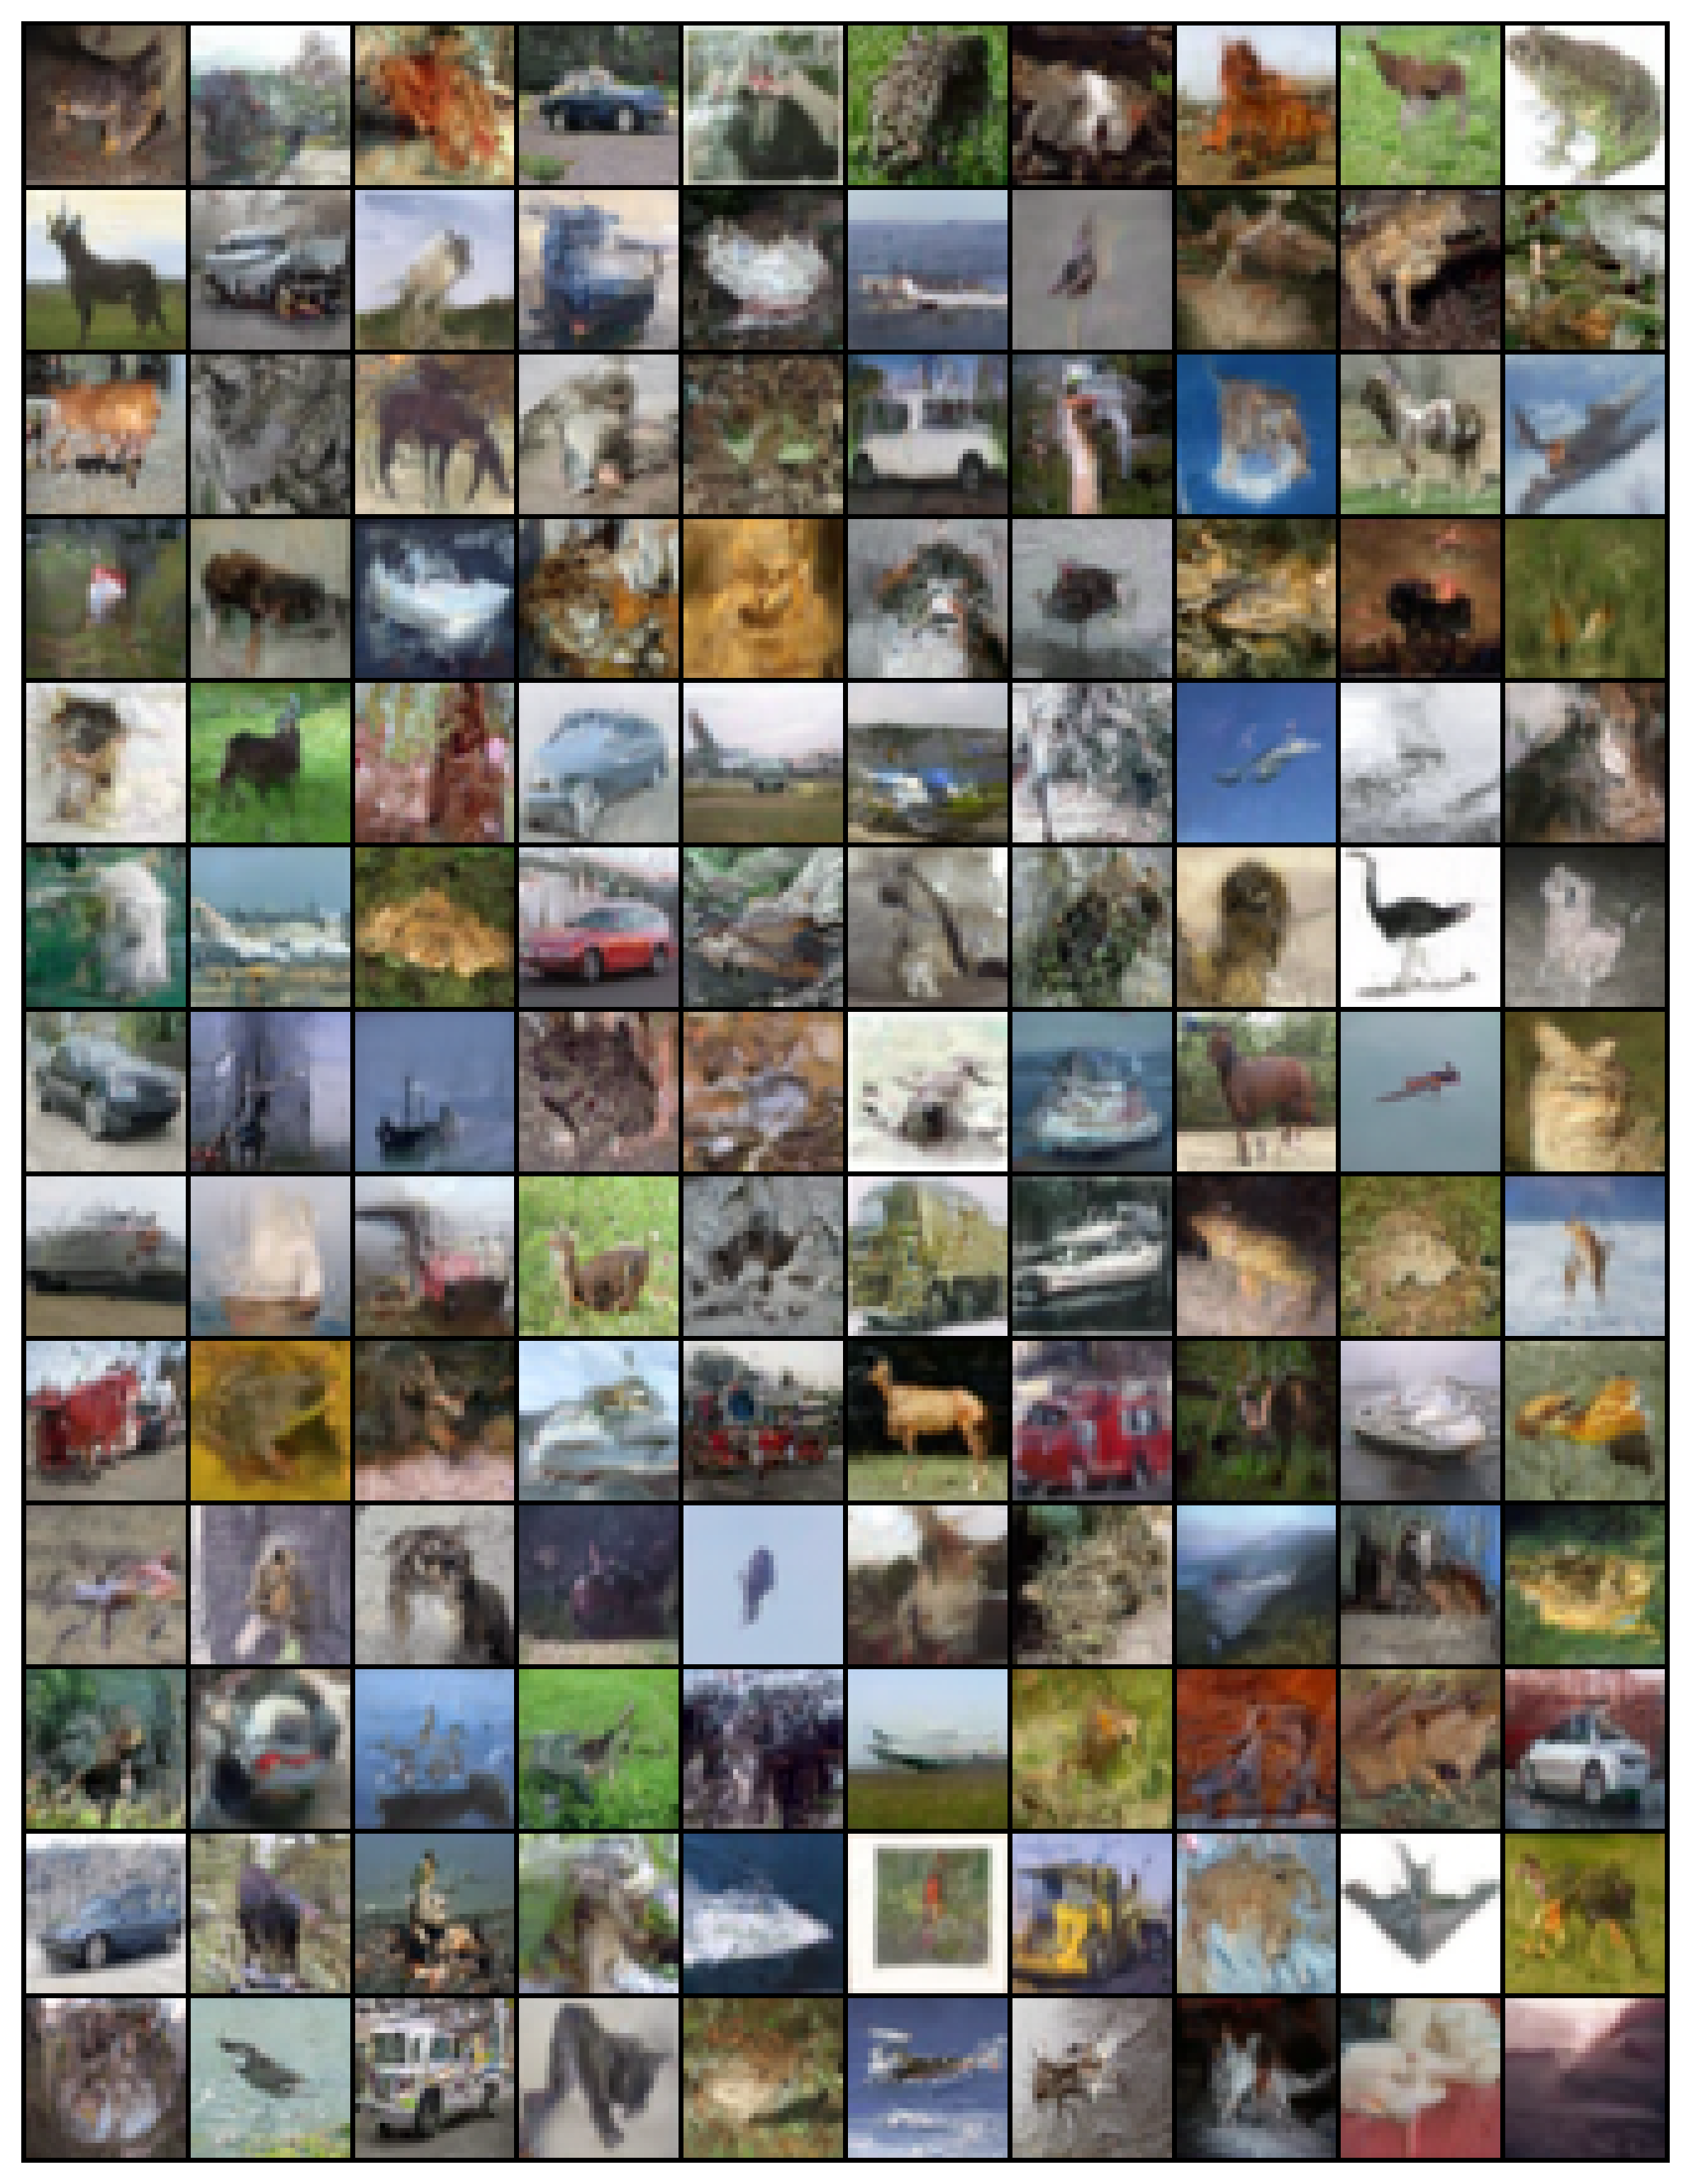

In [5]:
from scipy.integrate import solve_ivp

@torch.inference_mode()
def rk45(f, z0, startT=0., endT=1.0):
    def f_np(t, z, func, shape):
        z_tensor = torch.tensor(z, dtype=torch.float32, device=device).reshape(shape)
        t_tensor = t * torch.ones(shape[0], device=device)
        dz_tensor = func(z_tensor, t_tensor)   # Dit expects X_t of (B, C, H, W), and t of (B,)
        return dz_tensor.detach().cpu().numpy().reshape((-1,))
    
    shape = z0.shape
    z0_np = z0.cpu().numpy().flatten()
    t_span = (startT, endT)
    sol = solve_ivp(f_np, t_span, z0_np, args=(f, shape), method='RK45', t_eval=None, rtol=1e-3, atol=1e-3)
    z_final_np = sol.y[:, -1]
    nfe = sol.nfev
    print(f"Number of function evaluations: {nfe}")
    z_final = torch.tensor(z_final_np, dtype=torch.float32, device=device).reshape(shape)
    
    return z_final

X_0 = euler_sampler.X_0.clone()
X_1 = rk45(dit, X_0)
utils.plot_cifar_results(X_1)

101
torch.Size([130, 3, 32, 32])


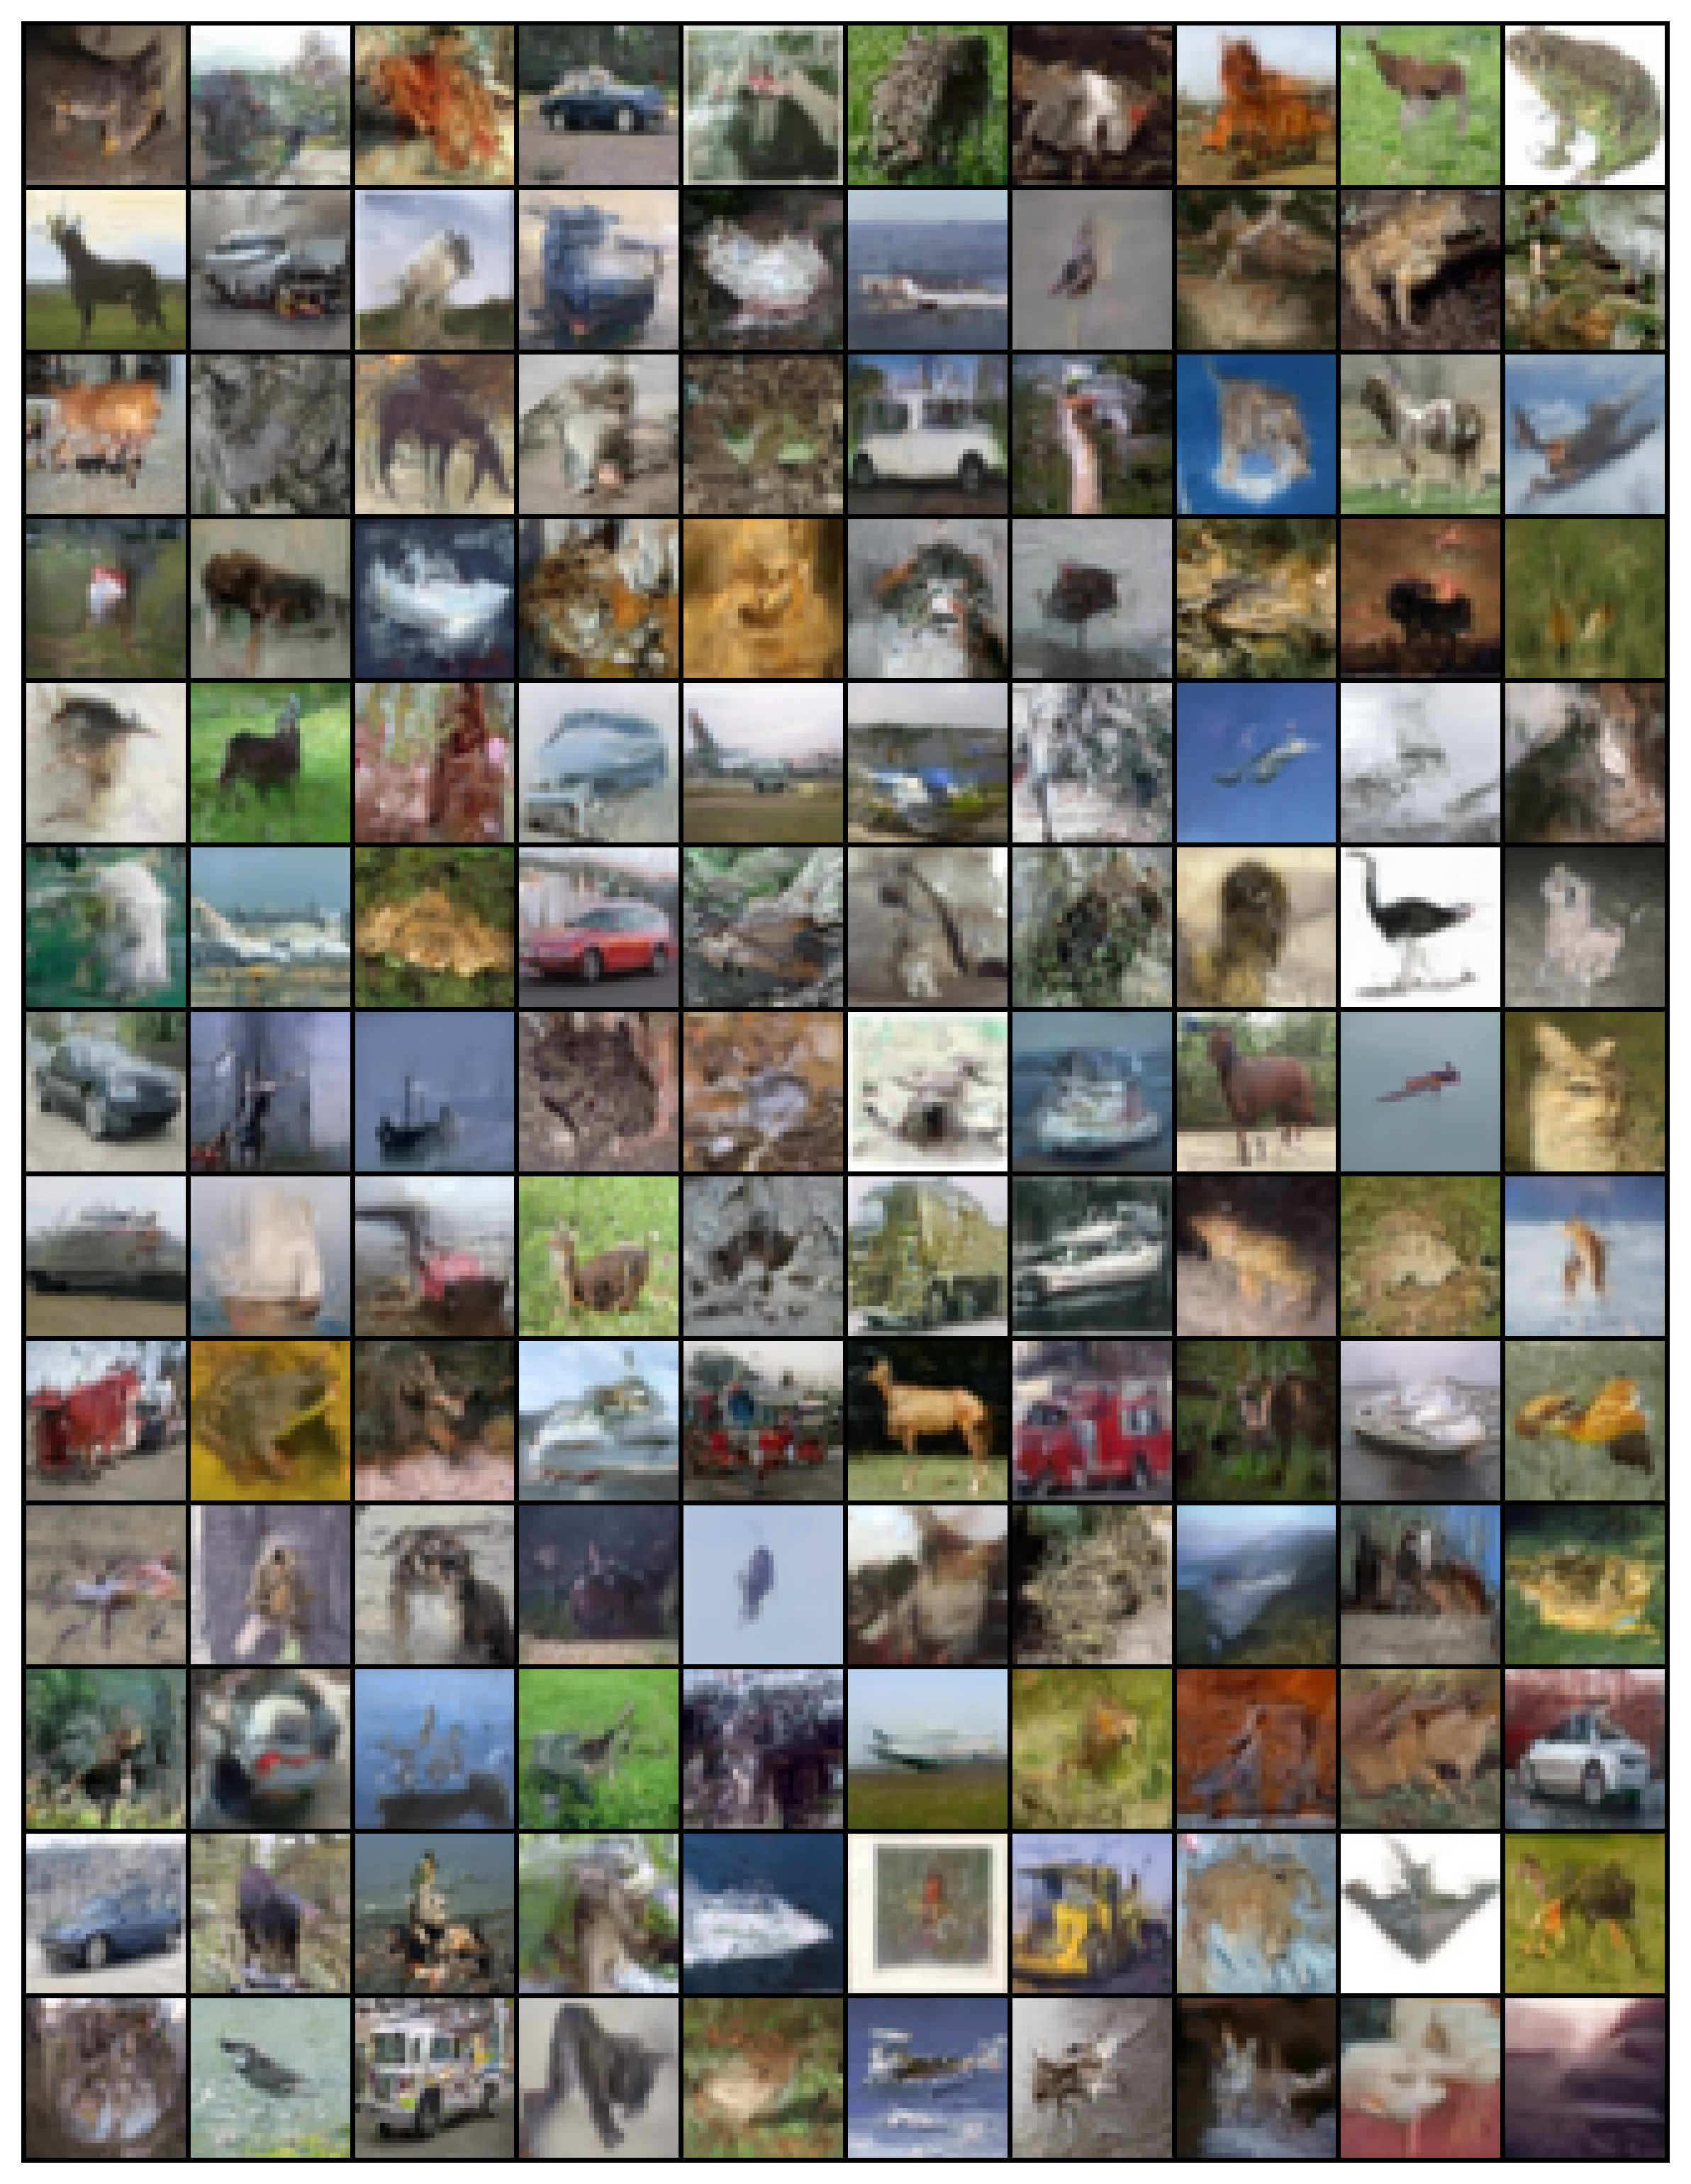

In [6]:
traj = euler_sampler.trajectories
print(len(traj))
X_1 = traj[-1]
print(X_1.shape)

utils.plot_cifar_results(X_1)

In [7]:
print(euler_sampler.time_points)

[0.0, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99]
